# Contextual Policies

Analyze the performance of our Whittle and Adaptive Policies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import json 
import argparse 
import sys
import secrets
from itertools import combinations
import gurobipy as gp
from gurobipy import GRB

In [3]:
import sys
sys.path.append('/usr0/home/naveenr/projects/food_rescue_preferences')

In [66]:
from rmab.simulator import run_multi_seed
from rmab.whittle_policies import *
from rmab.baseline_policies import *
from rmab.mcts_policies import *
from rmab.occupancy_policies import *
from rmab.utils import get_save_path, delete_duplicate_results, restrict_resources

In [5]:
is_jupyter = 'ipykernel' in sys.modules

In [30]:
if is_jupyter: 
    seed        = 44
    n_arms      = 10
    volunteers_per_arm = 1
    budget      = 2
    discount    = 0.9
    alpha       = 3 
    n_episodes  = 30
    episode_len = 50 
    n_epochs    = 1
    save_with_date = False 
    lamb = 0.5
    prob_distro = 'uniform'
    reward_type = "probability_context"
    reward_parameters = {'universe_size': 20, 'arm_set_low': 0, 'arm_set_high': 1}
    out_folder = 'unknown_parameters'
    time_limit = 100
    use_context = True
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_arms',         '-N', help='num beneficiaries (arms)', type=int, default=2)
    parser.add_argument('--volunteers_per_arm',         '-V', help='volunteers per arm', type=int, default=5)
    parser.add_argument('--episode_len',    '-H', help='episode length', type=int, default=50)
    parser.add_argument('--n_episodes',     '-T', help='num episodes', type=int, default=30)
    parser.add_argument('--budget',         '-B', help='budget', type=int, default=3)
    parser.add_argument('--n_epochs',       '-E', help='number of epochs (num_repeats)', type=int, default=1)
    parser.add_argument('--discount',       '-d', help='discount factor', type=float, default=0.9)
    parser.add_argument('--alpha',          '-a', help='alpha: for conf radius', type=float, default=3)
    parser.add_argument('--lamb',          '-l', help='lambda for matching-engagement tradeoff', type=float, default=0.5)
    parser.add_argument('--universe_size', help='For set cover, total num unvierse elems', type=int, default=10)
    parser.add_argument('--arm_set_low', help='Least size of arm set, for set cover', type=float, default=3)
    parser.add_argument('--arm_set_high', help='Largest size of arm set, for set cover', type=float, default=6)
    parser.add_argument('--reward_type',          '-r', help='Which type of custom reward', type=str, default='set_cover')
    parser.add_argument('--seed',           '-s', help='random seed', type=int, default=42)
    parser.add_argument('--prob_distro',           '-p', help='which prob distro [uniform,uniform_small,uniform_large,normal]', type=str, default='uniform')
    parser.add_argument('--out_folder', help='Which folder to write results to', type=str, default='iterative')
    parser.add_argument('--time_limit', help='Online time limit for computation', type=float, default=100)
    parser.add_argument('--use_date', action='store_true')

    args = parser.parse_args()

    n_arms      = args.n_arms
    volunteers_per_arm = args.volunteers_per_arm
    budget      = args.budget
    discount    = args.discount
    alpha       = args.alpha 
    seed        = args.seed
    n_episodes  = args.n_episodes
    episode_len = args.episode_len
    n_epochs    = args.n_epochs
    lamb = args.lamb
    save_with_date = args.use_date
    prob_distro = args.prob_distro
    out_folder = args.out_folder
    reward_type = args.reward_type
    reward_parameters = {'universe_size': args.universe_size,
                        'arm_set_low': args.arm_set_low, 
                        'arm_set_high': args.arm_set_high}
    time_limit = args.time_limit 
    context_dim = n_arms*volunteers_per_arm

save_name = secrets.token_hex(4)  

In [31]:
results = {}
results['parameters'] = {'seed'      : seed,
        'n_arms'    : n_arms,
        'volunteers_per_arm': volunteers_per_arm, 
        'budget'    : budget,
        'discount'  : discount, 
        'alpha'     : alpha, 
        'n_episodes': n_episodes, 
        'episode_len': episode_len, 
        'n_epochs'  : n_epochs, 
        'lamb': lamb,
        'prob_distro': prob_distro, 
        'reward_type': reward_type, 
        'universe_size': reward_parameters['universe_size'],
        'arm_set_low': reward_parameters['arm_set_low'], 
        'arm_set_high': reward_parameters['arm_set_high'],
        'time_limit': time_limit, 
        'use_context': use_context
        } 

## Occupancy Measure

In [32]:
seed_list = [seed]
restrict_resources()

In [51]:
policy = random_policy
name = "random"

rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
results['{}_reward'.format(name)] = rewards['reward']
results['{}_match'.format(name)] =  rewards['match'] 
results['{}_active'.format(name)] = rewards['active_rate']
results['{}_time'.format(name)] =  rewards['time']
print(np.mean(rewards['reward']))

cohort [ 6 61 24 28 93  0 91 23 74 73]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
Took 0.5036983489990234 time for inference and 0.0004925727844238281 time for training
0.30208567105994144


In [52]:
policy = greedy_policy
name = "greedy"

rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
results['{}_reward'.format(name)] = rewards['reward']
results['{}_match'.format(name)] =  rewards['match'] 
results['{}_active'.format(name)] = rewards['active_rate']
results['{}_time'.format(name)] =  rewards['time']
print(np.mean(rewards['reward']))

cohort [ 6 61 24 28 93  0 91 23 74 73]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
Took 0.9506993293762207 time for inference and 0.0007562637329101562 time for training
0.42782865635924355


In [53]:
if n_arms * volunteers_per_arm <= 4:
    policy = q_iteration_policy
    per_epoch_function = q_iteration_custom_epoch()
    name = "optimal"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],per_epoch_function=per_epoch_function,test_length=episode_len*(n_episodes%50))
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

In [54]:
if n_arms * volunteers_per_arm <= 1000:
    policy = whittle_policy 
    name = "linear_whittle"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

cohort [ 6 61 24 28 93  0 91 23 74 73]
Match probs [0.6464105624033935, 0.028544667945797242, 0.03768029232900816, 0.0182551076829518, 0.6273932545535863, 0.8348421486656494, 0.9969792586179441, 0.01585780035126383, 0.9327638698856681, 0.6415666006071534]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
Took 0.7975940704345703 time for inference and 0.001750946044921875 time for training
0.42560622109522167


In [55]:
if n_arms * volunteers_per_arm <= 1000:
    policy = shapley_whittle_custom_policy 
    name = "shapley_whittle_custom"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

cohort [ 6 61 24 28 93  0 91 23 74 73]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
Took 0.7736258506774902 time for inference and 0.2330608367919922 time for training
0.42560622109522167


In [56]:
if n_arms * volunteers_per_arm <= 1000:
    policy = regression_policy 
    name = "regression_whittle"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

cohort [ 6 61 24 28 93  0 91 23 74 73]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
Took 0.8108088970184326 time for inference and 0.028658628463745117 time for training
0.42842611350033244


In [57]:
if n_arms * volunteers_per_arm <= 1000:
    policy = occupancy_measure_linear 
    name = "occupancy_measure_linear"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

cohort [ 6 61 24 28 93  0 91 23 74 73]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
Took 3.0176427364349365 time for inference and 0.10313963890075684 time for training
0.42448692078557165


In [58]:
if n_arms * volunteers_per_arm <= 1000:
    policy = occupancy_measure_shapley 
    name = "occupancy_measure_shapley"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

cohort [ 6 61 24 28 93  0 91 23 74 73]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
Took 2.9885637760162354 time for inference and 0.2987332344055176 time for training
0.42448692078557165


In [79]:
if n_arms * volunteers_per_arm <= 1000 and use_context:
    policy = occupancy_measure_shapley_contextual 
    name = "occupancy_measure_shapley"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))
    

cohort [ 6 61 24 28 93  0 91 23 74 73]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
Took 120.44960165023804 time for inference and 0.00046515464782714844 time for training
0.42993704852947645


In [59]:
if n_arms * volunteers_per_arm <= 1000:
    policy = occupancy_measure_learn_shapley 
    name = "occupancy_measure_learn_shapley"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_predicted_regression'.format(name)] = list(simulator.predicted_regression)
    results['{}_actual_regression'.format(name)] = list(simulator.actual_regression)
    print(np.mean(rewards['reward']))

cohort [ 6 61 24 28 93  0 91 23 74 73]
instance 0, ep 1
Mem [0.20207827 0.20569939 0.10015009 0.04658524 0.29079465 0.27838352
 0.         0.36037708 0.         0.38698717]
Real [0.46098838 0.12496121 0.12931173 0.12008338 0.4493804  0.58034846
 0.68936815 0.1189503  0.64549157 0.45802404]
14 0.1519153007688595
instance 0, ep 2
Mem [2.02078267e-01 2.29597727e-01 1.00150089e-01 3.46360758e-02
 3.14692983e-01 3.02281854e-01 1.38777878e-17 3.00631244e-01
 1.26291969e-01 3.39190505e-01]
Real [0.46098838 0.12496121 0.12931173 0.12008338 0.4493804  0.58034846
 0.68936815 0.1189503  0.64549157 0.45802404]
16 0.27444517168932864
instance 0, ep 3
Mem [2.02078267e-01 2.46540910e-01 1.00150089e-01 5.49678959e-02
 2.74029343e-01 3.19225038e-01 4.85722573e-17 3.25481247e-01
 1.60178336e-01 3.05304138e-01]
Real [0.46098838 0.12496121 0.12931173 0.12008338 0.4493804  0.58034846
 0.68936815 0.1189503  0.64549157 0.45802404]
17 0.1989313331516097
instance 0, ep 4
Mem [ 2.02078267e-01  2.32112847e-01  1

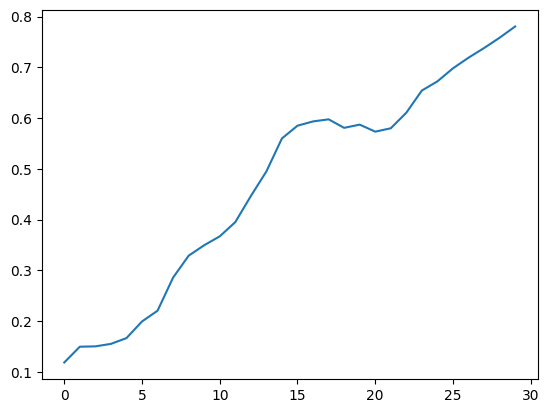

In [60]:
plt.plot(np.cumsum(results['regression_whittle_reward']) - np.cumsum(results['occupancy_measure_learn_shapley_reward']))

In [84]:
if n_arms * volunteers_per_arm <= 1000 and use_context:
    policy = occupancy_measure_learn_shapley_contextual 
    name = "occupancy_measure_learn_shapley"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_predicted_regression'.format(name)] = list(simulator.predicted_regression)
    results['{}_actual_regression'.format(name)] = list(simulator.actual_regression)
    print(np.mean(rewards['reward']))

cohort [ 6 61 24 28 93  0 91 23 74 73]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
Took 368.9375021457672 time for inference and 0.0006377696990966797 time for training
0.4326696203316666


In [62]:
if n_arms * volunteers_per_arm <= 1000:
    policy = occupancy_measure_learn_shapley_confidence
    name = "occupancy_measure_learn_shapley"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_predicted_regression'.format(name)] = list(simulator.predicted_regression)
    results['{}_actual_regression'.format(name)] = list(simulator.actual_regression)
    print(np.mean(rewards['reward']))

cohort [ 6 61 24 28 93  0 91 23 74 73]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
Took 5.341778755187988 time for inference and 0.0004985332489013672 time for training
0.40262200288185335


## Write Data

In [137]:
save_path = get_save_path(out_folder,save_name,seed,use_date=save_with_date)

In [138]:
delete_duplicate_results(out_folder,"",results)

In [ ]:
json.dump(results,open('../../results/'+save_path,'w'))